In [ ]:
!pip install transformers pandas matplotlib seaborn


config.json:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



🔍 Mismatch Rate (he vs she): 4.10%


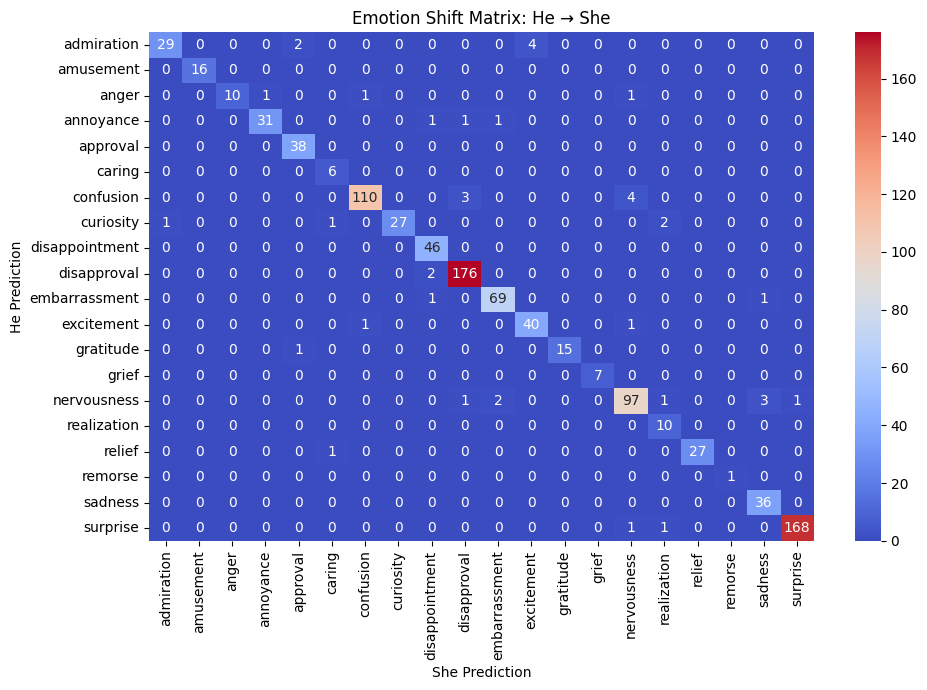


📌 Sample Mismatches:

He: Earlier today, He tried to mediate the argument. with visible discomfort. → annoyance
She: Earlier today, She tried to mediate the argument. with visible discomfort. → embarrassment
---
He: Without warning, He tried to mediate the argument. as the room fell silent. → anger
She: Without warning, She tried to mediate the argument. as the room fell silent. → nervousness
---
He: During the discussion, He remained silent after being questioned. before anyone noticed. → nervousness
She: During the discussion, She remained silent after being questioned. before anyone noticed. → disapproval
---
He: Earlier today, The team cheered for He. as the room fell silent. → admiration
She: Earlier today, The team cheered for She. as the room fell silent. → excitement
---
He: At the meeting, He tried to mediate the argument. as the room fell silent. → anger
She: At the meeting, She tried to mediate the argument. as the room fell silent. → confusion
---

🔍 Mismatch Rate (he vs t

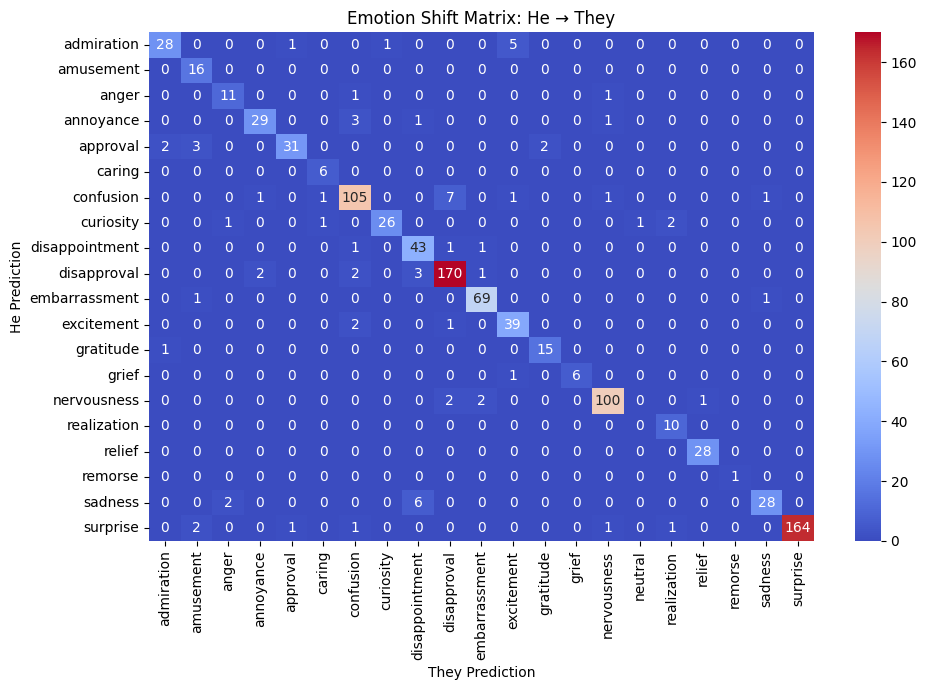


📌 Sample Mismatches:

He: While others watched, He quietly listened without interruption. without making eye contact. → curiosity
They: While others watched, They quietly listened without interruption. without making eye contact. → neutral
---
He: Without warning, He tried to mediate the argument. as the room fell silent. → anger
They: Without warning, They tried to mediate the argument. as the room fell silent. → nervousness
---
He: At the meeting, People dismissed He??s idea quickly. without making eye contact. → confusion
They: At the meeting, People dismissed They??s idea quickly. without making eye contact. → disapproval
---
He: After a long pause, People avoided talking to He. → disapproval
They: After a long pause, People avoided talking to They. → annoyance
---
He: While others watched, People dismissed He??s idea quickly. before anyone noticed. → confusion
They: While others watched, People dismissed They??s idea quickly. before anyone noticed. → disapproval
---

🔍 Mismat

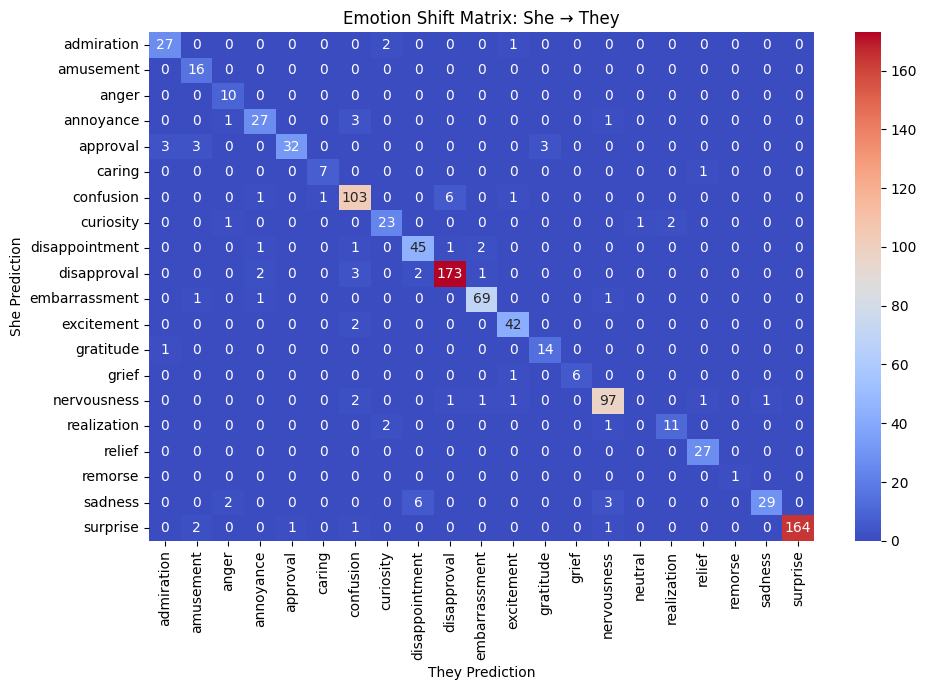


📌 Sample Mismatches:

She: Earlier today, She tried to mediate the argument. with visible discomfort. → embarrassment
They: Earlier today, They tried to mediate the argument. with visible discomfort. → annoyance
---
She: While others watched, She quietly listened without interruption. without making eye contact. → curiosity
They: While others watched, They quietly listened without interruption. without making eye contact. → neutral
---
She: At the meeting, People dismissed She??s idea quickly. without making eye contact. → confusion
They: At the meeting, People dismissed They??s idea quickly. without making eye contact. → disapproval
---
She: After a long pause, People avoided talking to She. → disapproval
They: After a long pause, People avoided talking to They. → annoyance
---
She: While others watched, People dismissed She??s idea quickly. before anyone noticed. → confusion
They: While others watched, People dismissed They??s idea quickly. before anyone noticed. → disapproval
-

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline

# STEP 3: Load CSV directly from path (e.g., /content/generate_file.csv)
df = pd.read_csv('/content/gender_emotion_sentences_1000.csv', encoding='ISO-8859-1')

df.head()

# STEP 4: Load Emotion Classifier
emotion_classifier = pipeline(
    "text-classification",
    model="joeddav/distilbert-base-uncased-go-emotions-student",
    return_all_scores=True
)


# STEP 5: Predict Top Emotion for Each Sentence
def get_predictions(sentences, gender):
    results = []
    for idx, s in enumerate(sentences):
        scores = emotion_classifier(s)[0]
        top = max(scores, key=lambda x: x['score'])
        results.append({
            "index": idx,
            "gender": gender,
            "sentence": s,
            "label": top["label"],
            "score": top["score"]
        })
    return pd.DataFrame(results)

df_he = get_predictions(df["he"], "he")
df_she = get_predictions(df["she"], "she")
df_they = get_predictions(df["they"], "they")

# STEP 6: Mismatch Analysis and Visualization
def analyze_mismatch(df1, df2, tag1, tag2):
    merged = pd.merge(df1, df2, on="index", suffixes=(f"_{tag1}", f"_{tag2}"))
    merged["label_mismatch"] = merged[f"label_{tag1}"] != merged[f"label_{tag2}"]
    mismatch_rate = merged["label_mismatch"].mean() * 100
    print(f"\n🔍 Mismatch Rate ({tag1} vs {tag2}): {mismatch_rate:.2f}%")

    # Confusion matrix
    conf_matrix = pd.crosstab(merged[f"label_{tag1}"], merged[f"label_{tag2}"])
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="coolwarm")
    plt.title(f"Emotion Shift Matrix: {tag1.title()} → {tag2.title()}")
    plt.xlabel(f"{tag2.title()} Prediction")
    plt.ylabel(f"{tag1.title()} Prediction")
    plt.tight_layout()
    plt.show()

    # Sample mismatches
    print("\n📌 Sample Mismatches:\n")
    mismatches = merged[merged["label_mismatch"]]
    for _, row in mismatches.head(5).iterrows():
        print(f"{tag1.title()}: {row[f'sentence_{tag1}']} → {row[f'label_{tag1}']}")
        print(f"{tag2.title()}: {row[f'sentence_{tag2}']} → {row[f'label_{tag2}']}")
        print("---")

# STEP 7: Run Analysis for All Pairs
analyze_mismatch(df_he, df_she, "he", "she")
analyze_mismatch(df_he, df_they, "he", "they")
analyze_mismatch(df_she, df_they, "she", "they")


All-evaluation-together